***
**Table des matières :**
* [1. Analyse sur les objets trouvés de grandes gares SNCF en 2020](#1)
    * [1.1 Les 10 gares avec les plus d'objets trouvés](#11)
    * [1.2 Les 10 natures d'objet les plus trouvées](#12)
    * [1.3 Les 10 types d'objet les plus trouvés](#13)
    * [1.4 La répartition annuelle des objets trouvés](#14)
    * [1.5 La répartition des objets trouvés dans la semaine](#15)
    * [1.6. La répartition des objets trouvés dans la journée](#16)
* [2. Analyse sur le nombre de personnes ayant attendu en espace de vente de grandes gares SNCF en 2019-2021](#2)
    * [2.1 La tendance au niveau du nombre de personnes ayant attentu plus de 30 minutes](#21)
    * [2.2 La tendance au niveau du nombre de personnes ayant attentu plus de 60 minutes](#22)
    * [2.3 La répartition du nombre de personnes ayant attendu en espace de vente dans chaque grande gare](#23)
***

**Étudiant :**
- Zhifeng LIANG

<a id='1'></a>
# **Analyse sur les objets trouvés de grandes gares SNCF en 2020**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pyspark
!sudo apt-get install language-pack-fr

     |████████████████████████████████| 212.3MB 58kB/s 
     |████████████████████████████████| 204kB 10.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=1f26a13d4d903fabc6b089b56e968d022bceb023ec49a6aef4aa3fd287b5ce36
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  language-pack-fr-base
The following NEW packages will be installed:
  language-pack-fr language-pack-fr-base
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,788 kB of archives.
After this operation, 21.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 language-pack-fr-base all 1:18.04+20180712 [2,875 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-up

In [ ]:
import calendar
import locale
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession

In [ ]:
# !locale -a

In [ ]:
# locale.setlocale(locale.LC_ALL, 'fr_FR.utf8')

In [ ]:
# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 2


In [ ]:
table_lost = sc.textFile('/content/drive/MyDrive/Cours_HETIC/Architecure_Programmation/data/sncf-lost-data-2020.csv')

In [ ]:
type(table_lost)

pyspark.rdd.RDD

In [ ]:
header_lost = table_lost.take(1)
table_lost_no_header = table_lost.filter(lambda row: row != header_lost[0])
print("Nombre de lignes : ", table_lost_no_header.count())
table_lost_splited = table_lost_no_header.map(lambda line: line.split(';'))

Nombre de lignes :  62042


<a id='11'></a>
## **1.1 Les 10 gares avec les plus d'objets trouvés**

In [ ]:
def get_top_10(n_column):
    data = table_lost_splited.map(lambda line: (line[n_column], 1)) \
                            .reduceByKey(lambda a,b:a + b) \
                            .sortBy(lambda pair: pair[1], ascending=False)
    return data.collect()[:10]

In [ ]:
stations_top_10 = get_top_10(2)

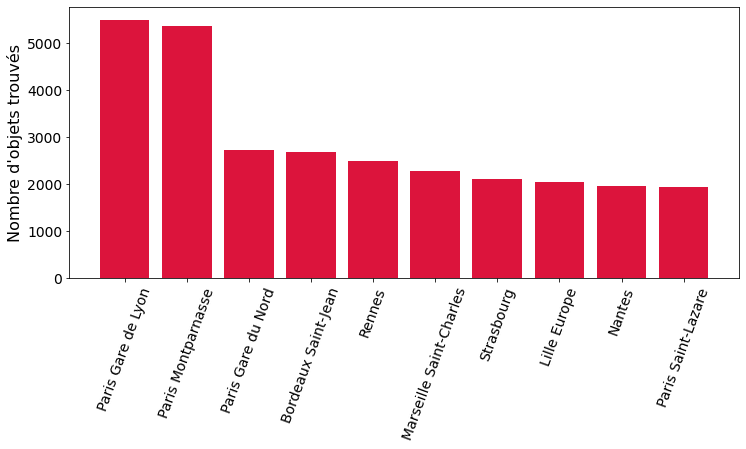

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(range(len(stations_top_10)), [val[1] for val in stations_top_10], color='crimson')
plt.xticks(range(len(stations_top_10)), [val[0] for val in stations_top_10], rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre d\'objets trouvés', fontsize=16)
plt.show()

<a id='12'></a>
## **1.2 Les 10 natures d'objet les plus trouvées**

In [ ]:
objects_nature_top_10 = get_top_10(4)

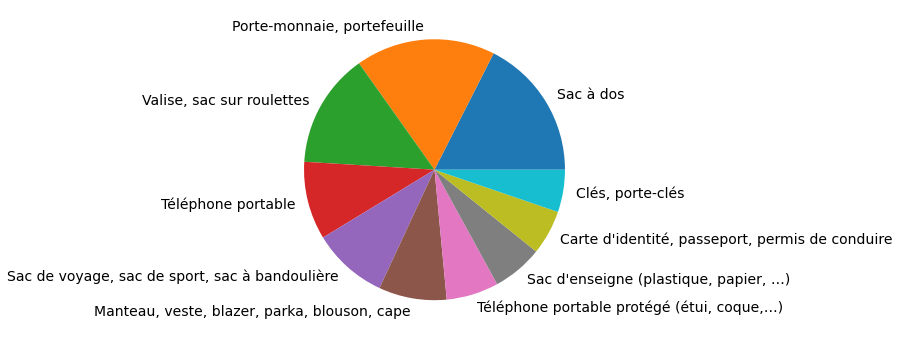

In [ ]:
plt.figure(figsize=(12,6))
plt.pie([val[1] for val in objects_nature_top_10], labels = [val[0] for val in objects_nature_top_10], textprops={'fontsize': 14})
plt.show()

<a id='13'></a>
## **1.3 Les 10 types d'objet les plus trouvés**

In [ ]:
objects_type_top_10 = get_top_10(5)

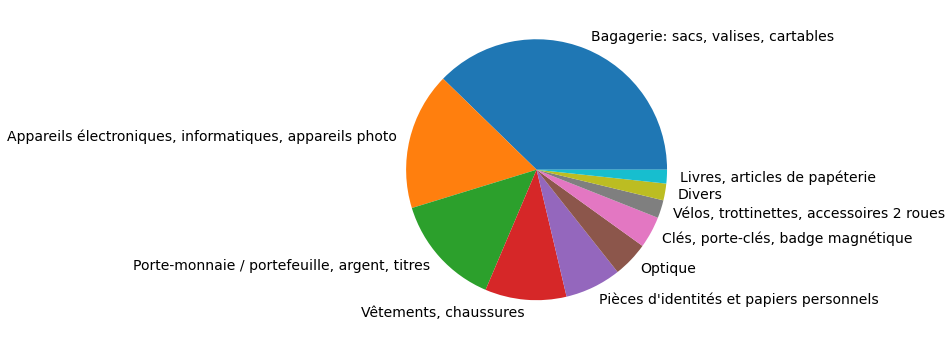

In [ ]:
plt.figure(figsize=(12,6))
plt.pie([val[1] for val in objects_type_top_10], labels = [val[0] for val in objects_type_top_10], textprops={'fontsize': 14})
plt.show()

<a id='14'></a>
## **1.4 La répartition annuelle des objets trouvés**

In [ ]:
months = table_lost_splited.map(lambda line: (line[0].split('-')[1], 1)) \
                    .reduceByKey(lambda a,b:a + b) \
                    .sortBy(lambda pair: pair[0], ascending=True)

months_collected = months.collect()

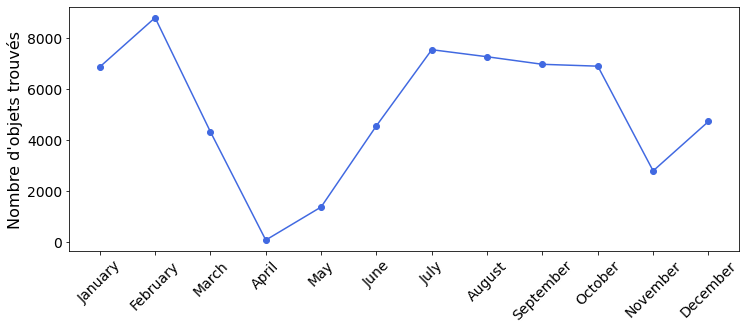

In [ ]:
plt.figure(figsize=(12,4.5))
plt.plot([val[1] for val in months_collected], color='royalblue', marker='o')
plt.xticks(range(len(months_collected)), [calendar.month_name[int(val[0])] for val in months_collected], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre d\'objets trouvés', fontsize=16)
plt.show()

<a id='15'></a>
## **1.5 La répartition des objets trouvés dans la semaine**

In [ ]:
weekdays = table_lost_splited.map(lambda line: (datetime.datetime.strptime(line[0].split('T')[0], '%Y-%m-%d').weekday(), 1)) \
                    .reduceByKey(lambda a,b:a + b) \
                    .sortBy(lambda pair: pair[0], ascending=True)

weekdays_collected = weekdays.collect()

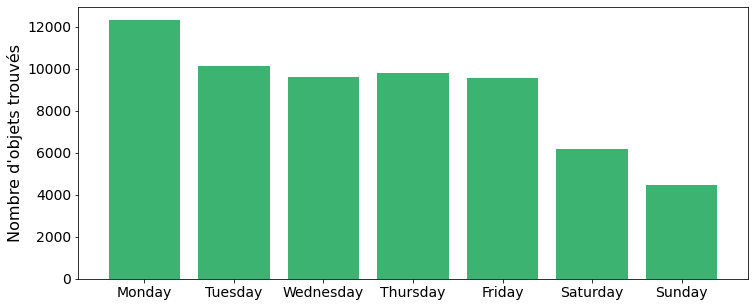

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(range(len(weekdays_collected)), [val[1] for val in weekdays_collected], color='mediumseagreen')
plt.xticks(range(len(weekdays_collected)), [calendar.day_name[val[0]] for val in weekdays_collected], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre d\'objets trouvés', fontsize=16)
plt.show()

<a id='16'></a>
## **1.6 La répartition des objets trouvés dans la journée**

In [ ]:
hours = table_lost_splited.map(lambda line: (line[0].split('T')[1].split(':')[0], 1)) \
                    .reduceByKey(lambda a,b:a + b) \
                    .sortBy(lambda pair: pair[0], ascending=True)

hours_collected = hours.collect()

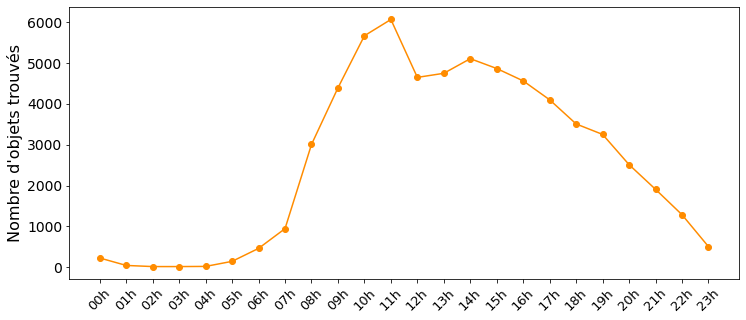

In [ ]:
plt.figure(figsize=(12,5))
plt.plot([val[1] for val in hours_collected], color='darkorange', marker='o')
plt.xticks(range(len(hours_collected)), [val[0] + 'h' for val in hours_collected], rotation=45, fontsize=13)
plt.yticks(fontsize=14)
plt.ylabel('Nombre d\'objets trouvés', fontsize=16)
plt.show()

<a id='2'></a>
# **Analyse sur le nombre de personnes ayant attendu en espace de vente de grandes gares SNCF en 2019-2021**

In [ ]:
table_waiting = sc.textFile('/content/drive/MyDrive/Cours_HETIC/Architecure_Programmation/data/attente-au-guichet.csv')

In [ ]:
header_waiting = table_waiting.take(1)
table_waiting_no_header = table_waiting.filter(lambda row: row != header_waiting[0])
print("Number of rows: ", table_waiting_no_header.count())
table_waiting_splited = table_waiting_no_header.map(lambda line: line.split(';'))

Number of rows:  3949


<a id='21'></a>
## **2.1 La tendance au niveau du nombre de personnes ayant attentu plus de 30 minutes**

In [ ]:
def get_dates_time(n_column):
    dates_time = table_waiting_splited.filter(lambda line: line[n_column] != '') \
                                    .map(lambda line: (datetime.datetime.strptime(line[2], '%Y-%m-%d'), int(float(line[n_column])))) \
                                    .reduceByKey(lambda a,b:a + b) \
                                    .sortBy(lambda pair: pair[0])
    return dates_time.collect()

In [ ]:
dates_time_30 = get_dates_time(3)

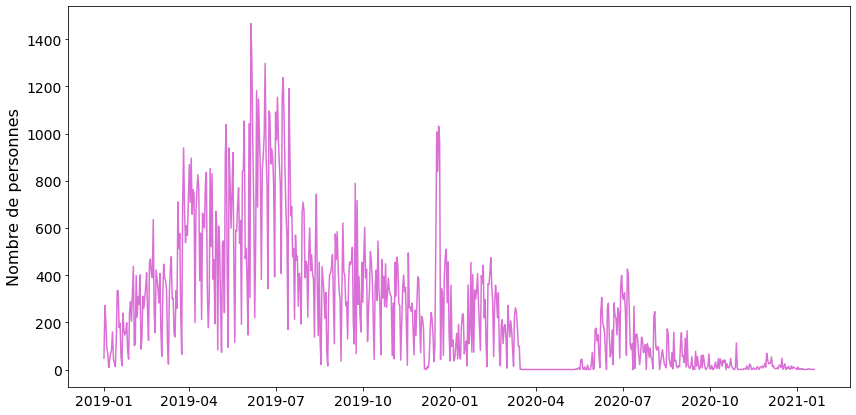

In [ ]:
plt.figure(figsize=(14,7))
plt.plot([val[0] for val in dates_time_30], [val[1] for val in dates_time_30], color='orchid')
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
# plt.gcf().autofmt_xdate() # Rotation
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre de personnes', fontsize=16)
plt.show()

<a id='22'></a>
## **2.2 La tendance au niveau du nombre de personnes ayant attentu plus de 60 minutes**

In [ ]:
dates_time_60 = get_dates_time(4)

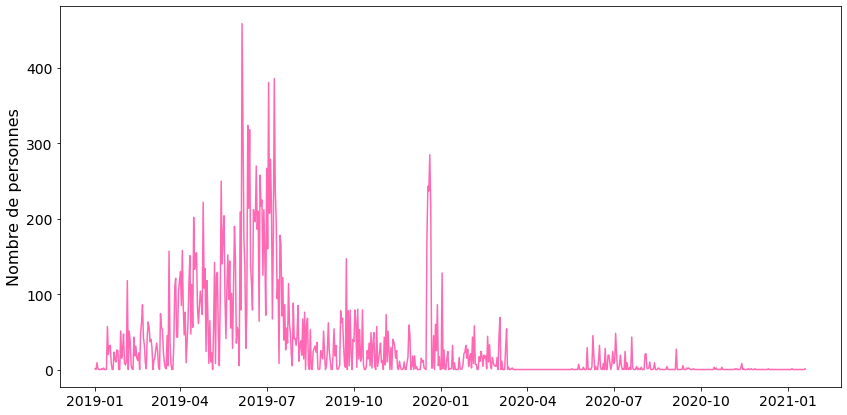

In [ ]:
plt.figure(figsize=(14,7))
plt.plot([val[0] for val in dates_time_60], [val[1] for val in dates_time_60], color='hotpink')
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
# plt.gcf().autofmt_xdate() # Rotation
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre de personnes', fontsize=16)
plt.show()

<a id='23'></a>
## **2.3 La répartition du nombre de personnes ayant attendu en espace de vente dans chaque grande gare**

In [ ]:
def get_stations_time(n_column):
    stations_time = table_waiting_splited.filter(lambda line: line[n_column] != '') \
                                        .map(lambda line: (line[0], int(float(line[n_column])))) \
                                        .reduceByKey(lambda a,b:a + b) \
                                        .sortBy(lambda pair: pair[0])
    return stations_time.collect()

In [ ]:
stations_time_30 = get_stations_time(3)
stations_time_60 = get_stations_time(4)

In [ ]:
stations_time_60

[('Gare Paris Est Alsace', 5551),
 ('Gare de Bordeaux St Jean', 1545),
 ('Gare de Paris Austerlitz', 8),
 ('Gare de Paris Saint Lazare', 5459),
 ('Gare de Strasbourg', 1982),
 ('NEC Paris Gare du Nord', 1625),
 ('NEV Gare de Paris Montparnasse', 337),
 ('Paris Gare de Lyon Fresque', 7250)]

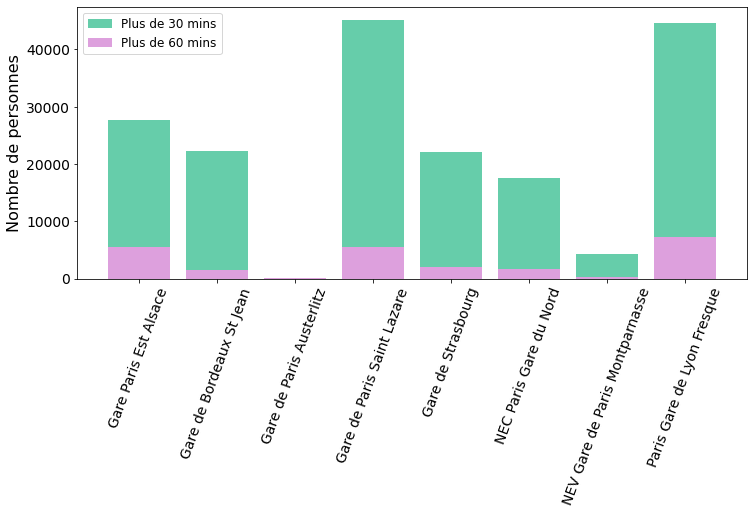

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(range(len(stations_time_30)), [val[1] for val in stations_time_30], color='mediumaquamarine')
plt.bar(range(len(stations_time_60)), [val[1] for val in stations_time_60], color='plum')
plt.xticks(range(len(stations_time_30)), [val[0] for val in stations_time_30], rotation = 70, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre de personnes', fontsize=16)
plt.legend(['Plus de 30 mins', 'Plus de 60 mins'], fontsize=12)
plt.show()